![](https://www.domsoria.com/wp-content/uploads/2019/11/keras.png)

# Deep Neural Network optimisation

We will build a deep network, and study several optimisation methods to avoid overfit and other issues affecting deep learning applications. 

**After this assignment you will be able to:**
- Build and apply a deep neural network to supervised learning, having a method to understand and face issues.

Let's get started!

In [1]:
# Import libraries
import time
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from utils.dnn_app_utils_v3 import *
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Normalizer, OneHotEncoder

from keras import layers
from keras.layers import Input, Add, Dense, Activation, Dropout
from keras.models import Model, load_model, Sequential
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.optimizers import Adam
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from utils.resnets_utils import *
from keras.initializers import glorot_uniform
from keras.regularizers import l2
import scipy.misc
from matplotlib.pyplot import imshow

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import skimage
import imageio

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 15) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(7)

Using TensorFlow backend.


### The Dataset


In [2]:
# generate 2d classification dataset
X, Y = make_moons(n_samples=150, noise=0.2, random_state=42)

X_train, X_test, Y_train_orig, Y_test_orig = train_test_split(X, Y, test_size=0.2)

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 2).T
Y_test = convert_to_one_hot(Y_test_orig, 2).T

print("number of training examples = " + str(X_train.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

number of training examples = 120
number of test examples = 30
X_train shape: (120, 2)
Y_train shape: (120, 2)
X_test shape: (30, 2)
Y_test shape: (30, 2)


Just for sake of clariness, let's plot our dataset

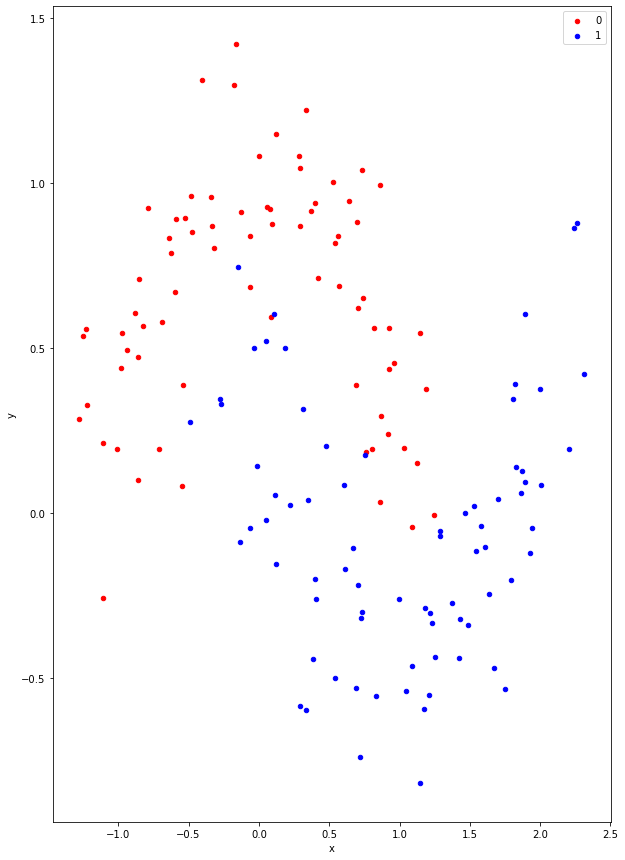

In [3]:
# scatter plot, dots colored by class value
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

Notice how the dataset cannot be separated by a line, so a Neural Network, being highly non linear may be what we need for this task.

## The model

In [4]:
# model building
n_x = X_train.shape[1] # number of features
model = Sequential()
model.add(Dense(1024, input_dim = n_x, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

opt = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              3072      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 528,898
Trainable params: 528,898
Non-trainable params: 0
_________________________________________________________________


In [5]:
# fit model
history = model.fit(X_train, Y_train, epochs=2000, validation_split=0.3,shuffle=True)

Train on 84 samples, validate on 36 samples
Epoch 1/2000
84/84 [==============================] - 0s 4ms/step - loss: 0.6814 - accuracy: 0.6369 - val_loss: 0.6681 - val_accuracy: 0.7778
Epoch 2/2000
84/84 [==============================] - 0s 239us/step - loss: 0.6641 - accuracy: 0.7798 - val_loss: 0.6513 - val_accuracy: 0.8056
Epoch 3/2000
84/84 [==============================] - 0s 295us/step - loss: 0.6488 - accuracy: 0.7738 - val_loss: 0.6355 - val_accuracy: 0.8056
Epoch 4/2000
84/84 [==============================] - 0s 258us/step - loss: 0.6329 - accuracy: 0.7857 - val_loss: 0.6207 - val_accuracy: 0.8056
Epoch 5/2000
84/84 [==============================] - 0s 299us/step - loss: 0.6183 - accuracy: 0.7857 - val_loss: 0.6067 - val_accuracy: 0.8056
Epoch 6/2000
84/84 [==============================] - 0s 308us/step - loss: 0.6037 - accuracy: 0.7857 - val_loss: 0.5932 - val_accuracy: 0.8056
Epoch 7/2000
84/84 [==============================] - 0s 321us/step - loss: 0.5898 - accuracy:

84/84 [==============================] - 0s 329us/step - loss: 0.2804 - accuracy: 0.8690 - val_loss: 0.4047 - val_accuracy: 0.7778
Epoch 114/2000
84/84 [==============================] - 0s 267us/step - loss: 0.2798 - accuracy: 0.8690 - val_loss: 0.4041 - val_accuracy: 0.7778
Epoch 115/2000
84/84 [==============================] - 0s 205us/step - loss: 0.2794 - accuracy: 0.8690 - val_loss: 0.4037 - val_accuracy: 0.7778
Epoch 116/2000
84/84 [==============================] - 0s 215us/step - loss: 0.2786 - accuracy: 0.8690 - val_loss: 0.4042 - val_accuracy: 0.7778
Epoch 117/2000
84/84 [==============================] - 0s 213us/step - loss: 0.2780 - accuracy: 0.8690 - val_loss: 0.4046 - val_accuracy: 0.7778
Epoch 118/2000
84/84 [==============================] - 0s 222us/step - loss: 0.2771 - accuracy: 0.8690 - val_loss: 0.4036 - val_accuracy: 0.7778
Epoch 119/2000
84/84 [==============================] - 0s 246us/step - loss: 0.2768 - accuracy: 0.8690 - val_loss: 0.4014 - val_accuracy: 

84/84 [==============================] - 0s 547us/step - loss: 0.1779 - accuracy: 0.8929 - val_loss: 0.3420 - val_accuracy: 0.8333
Epoch 226/2000
84/84 [==============================] - 0s 306us/step - loss: 0.1768 - accuracy: 0.8988 - val_loss: 0.3430 - val_accuracy: 0.8333
Epoch 227/2000
84/84 [==============================] - 0s 272us/step - loss: 0.1758 - accuracy: 0.9048 - val_loss: 0.3420 - val_accuracy: 0.8333
Epoch 228/2000
84/84 [==============================] - 0s 278us/step - loss: 0.1751 - accuracy: 0.9048 - val_loss: 0.3396 - val_accuracy: 0.8333
Epoch 229/2000
84/84 [==============================] - 0s 317us/step - loss: 0.1738 - accuracy: 0.9048 - val_loss: 0.3388 - val_accuracy: 0.8333
Epoch 230/2000
84/84 [==============================] - 0s 275us/step - loss: 0.1729 - accuracy: 0.9048 - val_loss: 0.3386 - val_accuracy: 0.8333
Epoch 231/2000
84/84 [==============================] - 0s 296us/step - loss: 0.1718 - accuracy: 0.9048 - val_loss: 0.3371 - val_accuracy: 

84/84 [==============================] - 0s 255us/step - loss: 0.0949 - accuracy: 0.9524 - val_loss: 0.2801 - val_accuracy: 0.8889
Epoch 338/2000
84/84 [==============================] - 0s 287us/step - loss: 0.0941 - accuracy: 0.9583 - val_loss: 0.2800 - val_accuracy: 0.8889
Epoch 339/2000
84/84 [==============================] - 0s 280us/step - loss: 0.0937 - accuracy: 0.9524 - val_loss: 0.2805 - val_accuracy: 0.8889
Epoch 340/2000
84/84 [==============================] - 0s 323us/step - loss: 0.0933 - accuracy: 0.9524 - val_loss: 0.2801 - val_accuracy: 0.8889
Epoch 341/2000
84/84 [==============================] - 0s 294us/step - loss: 0.0929 - accuracy: 0.9524 - val_loss: 0.2809 - val_accuracy: 0.8889
Epoch 342/2000
84/84 [==============================] - 0s 344us/step - loss: 0.0926 - accuracy: 0.9524 - val_loss: 0.2796 - val_accuracy: 0.8889
Epoch 343/2000
84/84 [==============================] - 0s 427us/step - loss: 0.0922 - accuracy: 0.9524 - val_loss: 0.2785 - val_accuracy: 

84/84 [==============================] - 0s 240us/step - loss: 0.0625 - accuracy: 0.9762 - val_loss: 0.2711 - val_accuracy: 0.8889
Epoch 450/2000
84/84 [==============================] - 0s 309us/step - loss: 0.0623 - accuracy: 0.9762 - val_loss: 0.2734 - val_accuracy: 0.8889
Epoch 451/2000
84/84 [==============================] - 0s 298us/step - loss: 0.0622 - accuracy: 0.9762 - val_loss: 0.2741 - val_accuracy: 0.8889
Epoch 452/2000
84/84 [==============================] - 0s 249us/step - loss: 0.0621 - accuracy: 0.9762 - val_loss: 0.2772 - val_accuracy: 0.8889
Epoch 453/2000
84/84 [==============================] - 0s 250us/step - loss: 0.0618 - accuracy: 0.9762 - val_loss: 0.2778 - val_accuracy: 0.8889
Epoch 454/2000
84/84 [==============================] - 0s 235us/step - loss: 0.0619 - accuracy: 0.9762 - val_loss: 0.2751 - val_accuracy: 0.8889
Epoch 455/2000
84/84 [==============================] - 0s 342us/step - loss: 0.0619 - accuracy: 0.9762 - val_loss: 0.2712 - val_accuracy: 

84/84 [==============================] - 0s 242us/step - loss: 0.0498 - accuracy: 0.9702 - val_loss: 0.2683 - val_accuracy: 0.8889
Epoch 562/2000
84/84 [==============================] - 0s 222us/step - loss: 0.0496 - accuracy: 0.9702 - val_loss: 0.2673 - val_accuracy: 0.8889
Epoch 563/2000
84/84 [==============================] - 0s 260us/step - loss: 0.0498 - accuracy: 0.9643 - val_loss: 0.2661 - val_accuracy: 0.8889
Epoch 564/2000
84/84 [==============================] - 0s 271us/step - loss: 0.0497 - accuracy: 0.9643 - val_loss: 0.2670 - val_accuracy: 0.8889
Epoch 565/2000
84/84 [==============================] - 0s 258us/step - loss: 0.0495 - accuracy: 0.9643 - val_loss: 0.2674 - val_accuracy: 0.8889
Epoch 566/2000
84/84 [==============================] - 0s 250us/step - loss: 0.0499 - accuracy: 0.9643 - val_loss: 0.2712 - val_accuracy: 0.8889
Epoch 567/2000
84/84 [==============================] - 0s 236us/step - loss: 0.0496 - accuracy: 0.9702 - val_loss: 0.2697 - val_accuracy: 

84/84 [==============================] - 0s 239us/step - loss: 0.0437 - accuracy: 0.9762 - val_loss: 0.2884 - val_accuracy: 0.9167
Epoch 674/2000
84/84 [==============================] - 0s 247us/step - loss: 0.0431 - accuracy: 0.9762 - val_loss: 0.2882 - val_accuracy: 0.9167
Epoch 675/2000
84/84 [==============================] - 0s 228us/step - loss: 0.0431 - accuracy: 0.9762 - val_loss: 0.2873 - val_accuracy: 0.9167
Epoch 676/2000
84/84 [==============================] - 0s 215us/step - loss: 0.0430 - accuracy: 0.9762 - val_loss: 0.2867 - val_accuracy: 0.9167
Epoch 677/2000
84/84 [==============================] - 0s 277us/step - loss: 0.0431 - accuracy: 0.9643 - val_loss: 0.2816 - val_accuracy: 0.9167
Epoch 678/2000
84/84 [==============================] - 0s 540us/step - loss: 0.0429 - accuracy: 0.9643 - val_loss: 0.2795 - val_accuracy: 0.9167
Epoch 679/2000
84/84 [==============================] - 0s 310us/step - loss: 0.0430 - accuracy: 0.9643 - val_loss: 0.2802 - val_accuracy: 

84/84 [==============================] - 0s 394us/step - loss: 0.0384 - accuracy: 0.9702 - val_loss: 0.2969 - val_accuracy: 0.9167
Epoch 786/2000
84/84 [==============================] - 0s 481us/step - loss: 0.0385 - accuracy: 0.9643 - val_loss: 0.2963 - val_accuracy: 0.9167
Epoch 787/2000
84/84 [==============================] - 0s 289us/step - loss: 0.0385 - accuracy: 0.9643 - val_loss: 0.2973 - val_accuracy: 0.9167
Epoch 788/2000
84/84 [==============================] - 0s 288us/step - loss: 0.0384 - accuracy: 0.9762 - val_loss: 0.2978 - val_accuracy: 0.9167
Epoch 789/2000
84/84 [==============================] - 0s 292us/step - loss: 0.0382 - accuracy: 0.9762 - val_loss: 0.3008 - val_accuracy: 0.9167
Epoch 790/2000
84/84 [==============================] - 0s 263us/step - loss: 0.0385 - accuracy: 0.9762 - val_loss: 0.3029 - val_accuracy: 0.9167
Epoch 791/2000
84/84 [==============================] - 0s 256us/step - loss: 0.0390 - accuracy: 0.9762 - val_loss: 0.2993 - val_accuracy: 

84/84 [==============================] - 0s 293us/step - loss: 0.0350 - accuracy: 0.9762 - val_loss: 0.3137 - val_accuracy: 0.9167
Epoch 898/2000
84/84 [==============================] - 0s 351us/step - loss: 0.0349 - accuracy: 0.9762 - val_loss: 0.3140 - val_accuracy: 0.9167
Epoch 899/2000
84/84 [==============================] - 0s 284us/step - loss: 0.0348 - accuracy: 0.9762 - val_loss: 0.3142 - val_accuracy: 0.9167
Epoch 900/2000
84/84 [==============================] - 0s 256us/step - loss: 0.0347 - accuracy: 0.9762 - val_loss: 0.3127 - val_accuracy: 0.9167
Epoch 901/2000
84/84 [==============================] - 0s 638us/step - loss: 0.0350 - accuracy: 0.9762 - val_loss: 0.3121 - val_accuracy: 0.9167
Epoch 902/2000
84/84 [==============================] - 0s 348us/step - loss: 0.0347 - accuracy: 0.9762 - val_loss: 0.3108 - val_accuracy: 0.9167
Epoch 903/2000
84/84 [==============================] - 0s 275us/step - loss: 0.0346 - accuracy: 0.9762 - val_loss: 0.3125 - val_accuracy: 

84/84 [==============================] - 0s 345us/step - loss: 0.0315 - accuracy: 0.9881 - val_loss: 0.3305 - val_accuracy: 0.8889
Epoch 1010/2000
84/84 [==============================] - 0s 387us/step - loss: 0.0321 - accuracy: 0.9762 - val_loss: 0.3277 - val_accuracy: 0.8889
Epoch 1011/2000
84/84 [==============================] - 0s 270us/step - loss: 0.0315 - accuracy: 0.9762 - val_loss: 0.3308 - val_accuracy: 0.8889
Epoch 1012/2000
84/84 [==============================] - 0s 327us/step - loss: 0.0317 - accuracy: 0.9881 - val_loss: 0.3315 - val_accuracy: 0.8889
Epoch 1013/2000
84/84 [==============================] - 0s 253us/step - loss: 0.0316 - accuracy: 0.9881 - val_loss: 0.3355 - val_accuracy: 0.8889
Epoch 1014/2000
84/84 [==============================] - 0s 292us/step - loss: 0.0314 - accuracy: 0.9762 - val_loss: 0.3387 - val_accuracy: 0.8889
Epoch 1015/2000
84/84 [==============================] - 0s 330us/step - loss: 0.0314 - accuracy: 0.9762 - val_loss: 0.3389 - val_accu

Epoch 1065/2000
84/84 [==============================] - 0s 266us/step - loss: 0.0299 - accuracy: 0.9762 - val_loss: 0.3312 - val_accuracy: 0.8889
Epoch 1066/2000
84/84 [==============================] - 0s 300us/step - loss: 0.0303 - accuracy: 0.9762 - val_loss: 0.3308 - val_accuracy: 0.8889
Epoch 1067/2000
84/84 [==============================] - 0s 271us/step - loss: 0.0302 - accuracy: 0.9762 - val_loss: 0.3349 - val_accuracy: 0.8889
Epoch 1068/2000
84/84 [==============================] - 0s 288us/step - loss: 0.0299 - accuracy: 0.9762 - val_loss: 0.3362 - val_accuracy: 0.8889
Epoch 1069/2000
84/84 [==============================] - 0s 216us/step - loss: 0.0302 - accuracy: 0.9762 - val_loss: 0.3374 - val_accuracy: 0.8889
Epoch 1070/2000
84/84 [==============================] - 0s 252us/step - loss: 0.0301 - accuracy: 0.9762 - val_loss: 0.3455 - val_accuracy: 0.8889
Epoch 1071/2000
84/84 [==============================] - 0s 362us/step - loss: 0.0302 - accuracy: 0.9881 - val_loss: 0

Epoch 1121/2000
84/84 [==============================] - 0s 314us/step - loss: 0.0290 - accuracy: 0.9762 - val_loss: 0.3515 - val_accuracy: 0.8889
Epoch 1122/2000
84/84 [==============================] - 0s 304us/step - loss: 0.0285 - accuracy: 0.9762 - val_loss: 0.3536 - val_accuracy: 0.8889
Epoch 1123/2000
84/84 [==============================] - 0s 324us/step - loss: 0.0284 - accuracy: 0.9762 - val_loss: 0.3533 - val_accuracy: 0.8889
Epoch 1124/2000
84/84 [==============================] - 0s 281us/step - loss: 0.0286 - accuracy: 0.9762 - val_loss: 0.3532 - val_accuracy: 0.8889
Epoch 1125/2000
84/84 [==============================] - 0s 282us/step - loss: 0.0283 - accuracy: 0.9881 - val_loss: 0.3539 - val_accuracy: 0.8889
Epoch 1126/2000
84/84 [==============================] - 0s 308us/step - loss: 0.0286 - accuracy: 0.9762 - val_loss: 0.3541 - val_accuracy: 0.8889
Epoch 1127/2000
84/84 [==============================] - 0s 314us/step - loss: 0.0287 - accuracy: 0.9881 - val_loss: 0

Epoch 1177/2000
84/84 [==============================] - 0s 437us/step - loss: 0.0275 - accuracy: 0.9881 - val_loss: 0.3726 - val_accuracy: 0.8889
Epoch 1178/2000
84/84 [==============================] - 0s 309us/step - loss: 0.0275 - accuracy: 0.9881 - val_loss: 0.3662 - val_accuracy: 0.8889
Epoch 1179/2000
84/84 [==============================] - 0s 341us/step - loss: 0.0271 - accuracy: 0.9881 - val_loss: 0.3645 - val_accuracy: 0.8889
Epoch 1180/2000
84/84 [==============================] - 0s 380us/step - loss: 0.0275 - accuracy: 0.9762 - val_loss: 0.3622 - val_accuracy: 0.8889
Epoch 1181/2000
84/84 [==============================] - 0s 398us/step - loss: 0.0273 - accuracy: 0.9762 - val_loss: 0.3607 - val_accuracy: 0.8889
Epoch 1182/2000
84/84 [==============================] - 0s 372us/step - loss: 0.0273 - accuracy: 0.9762 - val_loss: 0.3616 - val_accuracy: 0.8889
Epoch 1183/2000
84/84 [==============================] - 0s 372us/step - loss: 0.0273 - accuracy: 0.9762 - val_loss: 0

Epoch 1233/2000
84/84 [==============================] - 0s 374us/step - loss: 0.0260 - accuracy: 0.9881 - val_loss: 0.3837 - val_accuracy: 0.8889
Epoch 1234/2000
84/84 [==============================] - 0s 364us/step - loss: 0.0260 - accuracy: 0.9881 - val_loss: 0.3813 - val_accuracy: 0.8889
Epoch 1235/2000
84/84 [==============================] - 0s 276us/step - loss: 0.0260 - accuracy: 0.9881 - val_loss: 0.3803 - val_accuracy: 0.8889
Epoch 1236/2000
84/84 [==============================] - 0s 253us/step - loss: 0.0266 - accuracy: 0.9881 - val_loss: 0.3766 - val_accuracy: 0.8889
Epoch 1237/2000
84/84 [==============================] - 0s 260us/step - loss: 0.0260 - accuracy: 0.9881 - val_loss: 0.3798 - val_accuracy: 0.8889
Epoch 1238/2000
84/84 [==============================] - 0s 280us/step - loss: 0.0259 - accuracy: 0.9881 - val_loss: 0.3802 - val_accuracy: 0.8889
Epoch 1239/2000
84/84 [==============================] - 0s 270us/step - loss: 0.0261 - accuracy: 0.9881 - val_loss: 0

Epoch 1289/2000
84/84 [==============================] - 0s 282us/step - loss: 0.0250 - accuracy: 0.9762 - val_loss: 0.3886 - val_accuracy: 0.8889
Epoch 1290/2000
84/84 [==============================] - 0s 283us/step - loss: 0.0249 - accuracy: 0.9762 - val_loss: 0.3914 - val_accuracy: 0.8889
Epoch 1291/2000
84/84 [==============================] - 0s 679us/step - loss: 0.0249 - accuracy: 0.9881 - val_loss: 0.3917 - val_accuracy: 0.8889
Epoch 1292/2000
84/84 [==============================] - 0s 300us/step - loss: 0.0254 - accuracy: 0.9881 - val_loss: 0.3970 - val_accuracy: 0.8889
Epoch 1293/2000
84/84 [==============================] - 0s 311us/step - loss: 0.0250 - accuracy: 0.9881 - val_loss: 0.3990 - val_accuracy: 0.8889
Epoch 1294/2000
84/84 [==============================] - 0s 354us/step - loss: 0.0252 - accuracy: 0.9881 - val_loss: 0.3978 - val_accuracy: 0.8889
Epoch 1295/2000
84/84 [==============================] - 0s 325us/step - loss: 0.0252 - accuracy: 0.9881 - val_loss: 0

Epoch 1345/2000
84/84 [==============================] - 0s 356us/step - loss: 0.0243 - accuracy: 0.9881 - val_loss: 0.4219 - val_accuracy: 0.8889
Epoch 1346/2000
84/84 [==============================] - 0s 237us/step - loss: 0.0243 - accuracy: 0.9881 - val_loss: 0.4203 - val_accuracy: 0.8889
Epoch 1347/2000
84/84 [==============================] - 0s 307us/step - loss: 0.0246 - accuracy: 0.9881 - val_loss: 0.4187 - val_accuracy: 0.8889
Epoch 1348/2000
84/84 [==============================] - 0s 259us/step - loss: 0.0243 - accuracy: 0.9881 - val_loss: 0.4091 - val_accuracy: 0.8889
Epoch 1349/2000
84/84 [==============================] - 0s 300us/step - loss: 0.0245 - accuracy: 0.9881 - val_loss: 0.4021 - val_accuracy: 0.8889
Epoch 1350/2000
84/84 [==============================] - 0s 325us/step - loss: 0.0241 - accuracy: 0.9881 - val_loss: 0.4030 - val_accuracy: 0.8889
Epoch 1351/2000
84/84 [==============================] - 0s 334us/step - loss: 0.0239 - accuracy: 0.9881 - val_loss: 0

Epoch 1401/2000
84/84 [==============================] - 0s 261us/step - loss: 0.0234 - accuracy: 0.9762 - val_loss: 0.4157 - val_accuracy: 0.8889
Epoch 1402/2000
84/84 [==============================] - 0s 269us/step - loss: 0.0236 - accuracy: 0.9762 - val_loss: 0.4178 - val_accuracy: 0.8889
Epoch 1403/2000
84/84 [==============================] - 0s 267us/step - loss: 0.0232 - accuracy: 0.9762 - val_loss: 0.4173 - val_accuracy: 0.8889
Epoch 1404/2000
84/84 [==============================] - 0s 273us/step - loss: 0.0231 - accuracy: 0.9762 - val_loss: 0.4146 - val_accuracy: 0.8889
Epoch 1405/2000
84/84 [==============================] - 0s 271us/step - loss: 0.0235 - accuracy: 0.9881 - val_loss: 0.4118 - val_accuracy: 0.8889
Epoch 1406/2000
84/84 [==============================] - 0s 258us/step - loss: 0.0234 - accuracy: 0.9881 - val_loss: 0.4136 - val_accuracy: 0.8889
Epoch 1407/2000
84/84 [==============================] - 0s 202us/step - loss: 0.0231 - accuracy: 0.9881 - val_loss: 0

Epoch 1457/2000
84/84 [==============================] - 0s 274us/step - loss: 0.0225 - accuracy: 0.9881 - val_loss: 0.4424 - val_accuracy: 0.8889
Epoch 1458/2000
84/84 [==============================] - 0s 248us/step - loss: 0.0225 - accuracy: 0.9881 - val_loss: 0.4411 - val_accuracy: 0.8889
Epoch 1459/2000
84/84 [==============================] - 0s 576us/step - loss: 0.0224 - accuracy: 0.9881 - val_loss: 0.4407 - val_accuracy: 0.8889
Epoch 1460/2000
84/84 [==============================] - 0s 432us/step - loss: 0.0226 - accuracy: 0.9881 - val_loss: 0.4388 - val_accuracy: 0.8889
Epoch 1461/2000
84/84 [==============================] - 0s 364us/step - loss: 0.0225 - accuracy: 0.9881 - val_loss: 0.4367 - val_accuracy: 0.8889
Epoch 1462/2000
84/84 [==============================] - 0s 460us/step - loss: 0.0228 - accuracy: 0.9881 - val_loss: 0.4339 - val_accuracy: 0.8889
Epoch 1463/2000
84/84 [==============================] - 0s 403us/step - loss: 0.0227 - accuracy: 0.9881 - val_loss: 0

Epoch 1513/2000
84/84 [==============================] - 0s 234us/step - loss: 0.0217 - accuracy: 0.9762 - val_loss: 0.4418 - val_accuracy: 0.8889
Epoch 1514/2000
84/84 [==============================] - 0s 301us/step - loss: 0.0221 - accuracy: 0.9762 - val_loss: 0.4452 - val_accuracy: 0.8889
Epoch 1515/2000
84/84 [==============================] - 0s 290us/step - loss: 0.0218 - accuracy: 0.9762 - val_loss: 0.4424 - val_accuracy: 0.8889
Epoch 1516/2000
84/84 [==============================] - 0s 288us/step - loss: 0.0216 - accuracy: 0.9881 - val_loss: 0.4406 - val_accuracy: 0.8889
Epoch 1517/2000
84/84 [==============================] - 0s 320us/step - loss: 0.0218 - accuracy: 0.9881 - val_loss: 0.4416 - val_accuracy: 0.8889
Epoch 1518/2000
84/84 [==============================] - 0s 306us/step - loss: 0.0218 - accuracy: 0.9881 - val_loss: 0.4413 - val_accuracy: 0.8889
Epoch 1519/2000
84/84 [==============================] - 0s 306us/step - loss: 0.0216 - accuracy: 0.9881 - val_loss: 0

Epoch 1569/2000
84/84 [==============================] - 0s 241us/step - loss: 0.0210 - accuracy: 0.9881 - val_loss: 0.4626 - val_accuracy: 0.8611
Epoch 1570/2000
84/84 [==============================] - 0s 288us/step - loss: 0.0211 - accuracy: 0.9881 - val_loss: 0.4652 - val_accuracy: 0.8611
Epoch 1571/2000
84/84 [==============================] - 0s 291us/step - loss: 0.0211 - accuracy: 0.9881 - val_loss: 0.4666 - val_accuracy: 0.8611
Epoch 1572/2000
84/84 [==============================] - 0s 290us/step - loss: 0.0212 - accuracy: 0.9881 - val_loss: 0.4685 - val_accuracy: 0.8611
Epoch 1573/2000
84/84 [==============================] - 0s 284us/step - loss: 0.0211 - accuracy: 0.9881 - val_loss: 0.4720 - val_accuracy: 0.8611
Epoch 1574/2000
84/84 [==============================] - 0s 293us/step - loss: 0.0211 - accuracy: 0.9881 - val_loss: 0.4767 - val_accuracy: 0.8611
Epoch 1575/2000
84/84 [==============================] - 0s 237us/step - loss: 0.0215 - accuracy: 0.9881 - val_loss: 0

Epoch 1625/2000
84/84 [==============================] - 0s 375us/step - loss: 0.0213 - accuracy: 0.9881 - val_loss: 0.4791 - val_accuracy: 0.8611
Epoch 1626/2000
84/84 [==============================] - 0s 366us/step - loss: 0.0211 - accuracy: 0.9881 - val_loss: 0.4708 - val_accuracy: 0.8889
Epoch 1627/2000
84/84 [==============================] - 0s 241us/step - loss: 0.0208 - accuracy: 0.9881 - val_loss: 0.4675 - val_accuracy: 0.8889
Epoch 1628/2000
84/84 [==============================] - 0s 250us/step - loss: 0.0206 - accuracy: 0.9881 - val_loss: 0.4630 - val_accuracy: 0.8889
Epoch 1629/2000
84/84 [==============================] - 0s 557us/step - loss: 0.0208 - accuracy: 0.9881 - val_loss: 0.4625 - val_accuracy: 0.8889
Epoch 1630/2000
84/84 [==============================] - 0s 390us/step - loss: 0.0205 - accuracy: 0.9881 - val_loss: 0.4629 - val_accuracy: 0.8889
Epoch 1631/2000
84/84 [==============================] - 0s 402us/step - loss: 0.0209 - accuracy: 0.9762 - val_loss: 0

Epoch 1681/2000
84/84 [==============================] - 0s 335us/step - loss: 0.0203 - accuracy: 0.9762 - val_loss: 0.4924 - val_accuracy: 0.8611
Epoch 1682/2000
84/84 [==============================] - 0s 379us/step - loss: 0.0200 - accuracy: 0.9881 - val_loss: 0.4951 - val_accuracy: 0.8611
Epoch 1683/2000
84/84 [==============================] - 0s 373us/step - loss: 0.0202 - accuracy: 0.9881 - val_loss: 0.4987 - val_accuracy: 0.8611
Epoch 1684/2000
84/84 [==============================] - 0s 344us/step - loss: 0.0199 - accuracy: 0.9881 - val_loss: 0.5001 - val_accuracy: 0.8611
Epoch 1685/2000
84/84 [==============================] - 0s 341us/step - loss: 0.0199 - accuracy: 1.0000 - val_loss: 0.4992 - val_accuracy: 0.8611
Epoch 1686/2000
84/84 [==============================] - 0s 378us/step - loss: 0.0201 - accuracy: 0.9881 - val_loss: 0.5001 - val_accuracy: 0.8611
Epoch 1687/2000
84/84 [==============================] - 0s 334us/step - loss: 0.0203 - accuracy: 0.9881 - val_loss: 0

Epoch 1737/2000
84/84 [==============================] - 0s 289us/step - loss: 0.0200 - accuracy: 0.9881 - val_loss: 0.5097 - val_accuracy: 0.8611
Epoch 1738/2000
84/84 [==============================] - 0s 273us/step - loss: 0.0198 - accuracy: 0.9881 - val_loss: 0.5148 - val_accuracy: 0.8611
Epoch 1739/2000
84/84 [==============================] - 0s 259us/step - loss: 0.0197 - accuracy: 0.9881 - val_loss: 0.5149 - val_accuracy: 0.8611
Epoch 1740/2000
84/84 [==============================] - 0s 282us/step - loss: 0.0198 - accuracy: 0.9881 - val_loss: 0.5099 - val_accuracy: 0.8611
Epoch 1741/2000
84/84 [==============================] - 0s 286us/step - loss: 0.0197 - accuracy: 0.9881 - val_loss: 0.5076 - val_accuracy: 0.8611
Epoch 1742/2000
84/84 [==============================] - 0s 312us/step - loss: 0.0194 - accuracy: 1.0000 - val_loss: 0.5069 - val_accuracy: 0.8611
Epoch 1743/2000
84/84 [==============================] - 0s 327us/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 0

Epoch 1793/2000
84/84 [==============================] - 0s 414us/step - loss: 0.0193 - accuracy: 0.9881 - val_loss: 0.5338 - val_accuracy: 0.8611
Epoch 1794/2000
84/84 [==============================] - 0s 477us/step - loss: 0.0194 - accuracy: 0.9881 - val_loss: 0.5352 - val_accuracy: 0.8611
Epoch 1795/2000
84/84 [==============================] - 0s 472us/step - loss: 0.0190 - accuracy: 0.9881 - val_loss: 0.5306 - val_accuracy: 0.8611
Epoch 1796/2000
84/84 [==============================] - 0s 387us/step - loss: 0.0190 - accuracy: 0.9881 - val_loss: 0.5237 - val_accuracy: 0.8611
Epoch 1797/2000
84/84 [==============================] - 0s 399us/step - loss: 0.0194 - accuracy: 0.9881 - val_loss: 0.5178 - val_accuracy: 0.8611
Epoch 1798/2000
84/84 [==============================] - 0s 273us/step - loss: 0.0193 - accuracy: 0.9881 - val_loss: 0.5175 - val_accuracy: 0.8611
Epoch 1799/2000
84/84 [==============================] - 0s 317us/step - loss: 0.0194 - accuracy: 0.9881 - val_loss: 0

Epoch 1849/2000
84/84 [==============================] - 0s 317us/step - loss: 0.0188 - accuracy: 0.9881 - val_loss: 0.5362 - val_accuracy: 0.8611
Epoch 1850/2000
84/84 [==============================] - 0s 282us/step - loss: 0.0187 - accuracy: 1.0000 - val_loss: 0.5400 - val_accuracy: 0.8611
Epoch 1851/2000
84/84 [==============================] - 0s 286us/step - loss: 0.0190 - accuracy: 0.9881 - val_loss: 0.5487 - val_accuracy: 0.8611
Epoch 1852/2000
84/84 [==============================] - 0s 265us/step - loss: 0.0186 - accuracy: 0.9881 - val_loss: 0.5507 - val_accuracy: 0.8611
Epoch 1853/2000
84/84 [==============================] - 0s 265us/step - loss: 0.0188 - accuracy: 0.9881 - val_loss: 0.5497 - val_accuracy: 0.8611
Epoch 1854/2000
84/84 [==============================] - 0s 242us/step - loss: 0.0186 - accuracy: 0.9881 - val_loss: 0.5493 - val_accuracy: 0.8611
Epoch 1855/2000
84/84 [==============================] - 0s 210us/step - loss: 0.0188 - accuracy: 0.9881 - val_loss: 0

Epoch 1905/2000
84/84 [==============================] - 0s 280us/step - loss: 0.0187 - accuracy: 0.9881 - val_loss: 0.5756 - val_accuracy: 0.8611
Epoch 1906/2000
84/84 [==============================] - 0s 309us/step - loss: 0.0182 - accuracy: 0.9881 - val_loss: 0.5692 - val_accuracy: 0.8611
Epoch 1907/2000
84/84 [==============================] - 0s 287us/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.5653 - val_accuracy: 0.8611
Epoch 1908/2000
84/84 [==============================] - 0s 306us/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.5618 - val_accuracy: 0.8611
Epoch 1909/2000
84/84 [==============================] - 0s 282us/step - loss: 0.0184 - accuracy: 1.0000 - val_loss: 0.5615 - val_accuracy: 0.8611
Epoch 1910/2000
84/84 [==============================] - 0s 325us/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.5593 - val_accuracy: 0.8611
Epoch 1911/2000
84/84 [==============================] - 0s 276us/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0

Epoch 1961/2000
84/84 [==============================] - 0s 332us/step - loss: 0.0186 - accuracy: 0.9881 - val_loss: 0.5715 - val_accuracy: 0.8611
Epoch 1962/2000
84/84 [==============================] - 0s 314us/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.5718 - val_accuracy: 0.8611
Epoch 1963/2000
84/84 [==============================] - 0s 307us/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 0.5729 - val_accuracy: 0.8611
Epoch 1964/2000
84/84 [==============================] - 0s 407us/step - loss: 0.0184 - accuracy: 1.0000 - val_loss: 0.5785 - val_accuracy: 0.8611
Epoch 1965/2000
84/84 [==============================] - 0s 257us/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.5762 - val_accuracy: 0.8611
Epoch 1966/2000
84/84 [==============================] - 0s 308us/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.5767 - val_accuracy: 0.8611
Epoch 1967/2000
84/84 [==============================] - 0s 302us/step - loss: 0.0182 - accuracy: 0.9881 - val_loss: 0

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


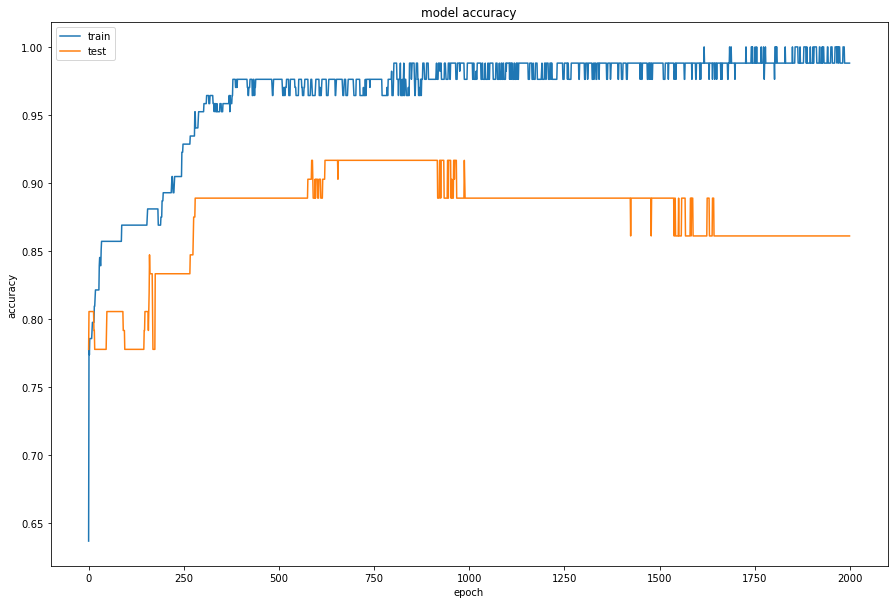

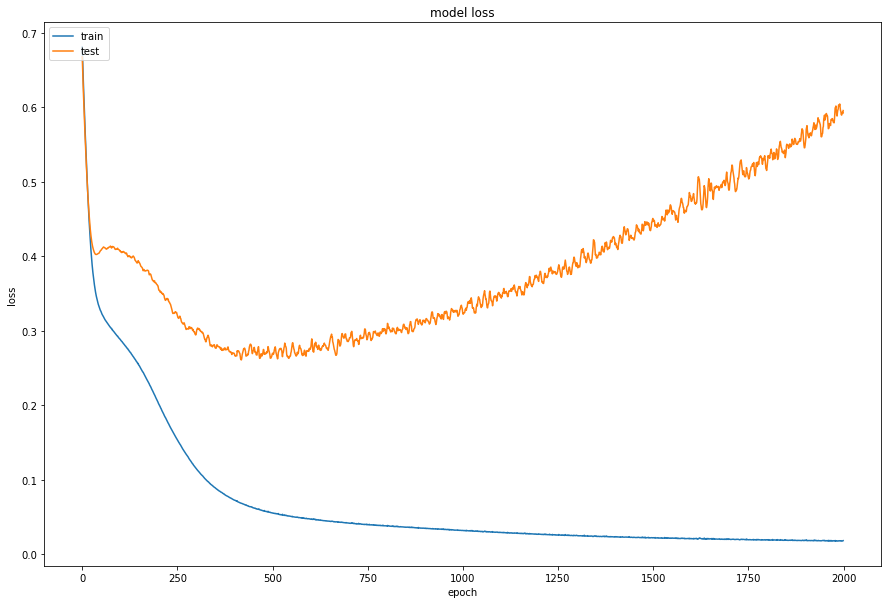

In [6]:
print(history.history.keys())

plt.figure(figsize=(15,10))

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(15,10))
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
train_metr = model.evaluate(X_train, Y_train, verbose=0)
results = model.evaluate(X_test, Y_test, verbose=0)

print(f'Training {model.metrics_names[0]}: {train_metr[0]} \nTraining {model.metrics_names[1]}: {train_metr[1]}' )
print('='*35)
print(f'Test {model.metrics_names[0]}: {results[0]} \nTest {model.metrics_names[1]}: {results[1]}' )

Training loss: 0.19111647804578144 
Training accuracy: 0.949999988079071
Test loss: 0.5187798738479614 
Test accuracy: 0.9666666388511658


We can see that the model has better performance on the training dataset than the test dataset, one possible sign of __overfitting__.

Let's plot decision boundaries to have a clearer picture

In [8]:
def plot_decision_boundary(X, y, model, steps=1000, cmap='Paired'):
    cmap = plt.get_cmap(cmap)

    # Define region of interest by data limits
    xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
    ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    labels = model.predict_classes(np.c_[xx.ravel(), yy.ravel()])

    # Plot decision boundary in region of interest
    z = labels.reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.5)

    # Get predicted labels on training data and plot
    train_labels = model.predict(X)
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, lw=0)

    return fig, ax

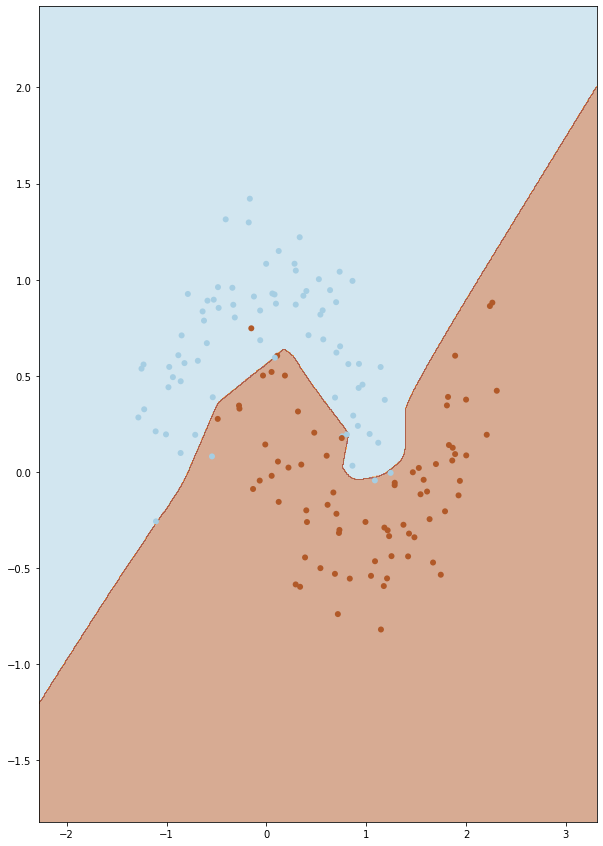

In [9]:
plot_decision_boundary(X, Y, model, steps=1000, cmap='Paired');

A much nicer figure (😉) can be seen [here](https://jamboard.google.com/d/1UmIdOUFZoUcjpPSOq_ryOyAjj5Houy87a--YxZSNi2g/edit?usp=sharing).

## The crucial question

> How do we fight overfit?

## Regularisation

As we have seen above, by an example, a central problem in machine learning is how to make an algorithm that will perform well not just on the training data, but also on new inputs. 
Many strategies used in machine learning are explicitly designed to reduce the test error, possibly at the expense of increased training error. These strategies are known collectively as _regularization_.

### Penalties

One of the most simple way to reduce overfit is to add a penalty term to the cost function.
Euristically, this _penalises_ the high-valued terms, reducing parameters' magnitude (each single node weight) and "simplifying" the model.

$$ J(\beta) = \frac{1}{n} \sum_k \mathcal{L}(\hat{y}^{(k)}, {y}^{(k)}) + \frac{\lambda}{p n} \Vert \beta \Vert_p^p $$

### Dropout

![](https://cdn-images-1.medium.com/max/1000/0*ZRRL-z_7ZxWpuryM.gif)

In a neural network, while training, we set a probability (can be different for each layer) of deleting some of the units of the layer. If $p = 1/2$, at each step we train the network on half of the units.
The guide principle is 
> _a smaller network is less prone to overfit_.

### Data augmentation

Another technique, really used in computer vision is _data augmentation_. 

With this, we mean a slight transformation of each training example (rotation, change of colour, blur, etc.) in order to have much more data and let the deep learning algorithm to have more experience of what an object is.

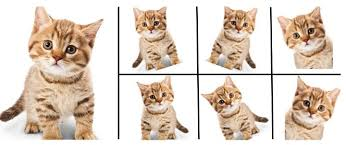

## Application: a guided exercise

We will use a famous dataset about a glass classification problem.

We have data about glass chemical compositions and we want to classify the type of glass.

Here the description of the dataset

__Attribute Information__:

* Id number: 1 to 214
* RI: refractive index
* Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
* Mg: Magnesium
* Al: Aluminum
* Si: Silicon
* K: Potassium
* Ca: Calcium
* Ba: Barium
* Fe: Iron
* Type of glass: (class attribute)
   1. building_windows_float_processed
   2. building_windows_non_float_processed
   3. vehicle_windows_float_processed
   4. vehicle_windows_non_float_processed (none in this database)
   5. containers
   6. tableware
   7. headlamps

The following cell loads the dataset.

In [5]:
# Loading the dataset
col_names = ['Id','RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','Type']
df = pd.read_csv("datasets/glass.data", names=col_names, index_col='Id')
colsx = df.columns[:-1]
colsy = 'Type'

X = df[colsx]
X = X.values
Y = df[colsy].values
Y = Y.reshape(-1)

#### Some preprocessing

In [6]:
X = StandardScaler().fit_transform(X)

Y = np.eye(7)[Y - 1] # we have 7 classes = 7 types of glass

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

n_x = X_train.shape[1] # number of features
n_c = Y_train.shape[1] # number of classes

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 171
number of test examples = 43
X_train shape: (171, 9)
Y_train shape: (171, 7)
X_test shape: (43, 9)
Y_test shape: (43, 7)


In [7]:
# create model
model = Sequential()
model.add(Dense(10, kernel_initializer='normal',input_dim=n_x, activation='relu'))
model.add(Dense(n_c, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                100       
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 77        
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=300, validation_split=0.1,shuffle=True)

Train on 153 samples, validate on 18 samples
Epoch 1/300
153/153 [==============================] - 0s 2ms/step - loss: 1.9621 - accuracy: 0.0915 - val_loss: 1.9289 - val_accuracy: 0.1667
Epoch 2/300
153/153 [==============================] - 0s 107us/step - loss: 1.9404 - accuracy: 0.2418 - val_loss: 1.9110 - val_accuracy: 0.2778
Epoch 3/300
153/153 [==============================] - 0s 54us/step - loss: 1.9188 - accuracy: 0.3464 - val_loss: 1.8936 - val_accuracy: 0.4444
Epoch 4/300
153/153 [==============================] - 0s 37us/step - loss: 1.8989 - accuracy: 0.4248 - val_loss: 1.8770 - val_accuracy: 0.4444
Epoch 5/300
153/153 [==============================] - 0s 106us/step - loss: 1.8796 - accuracy: 0.4575 - val_loss: 1.8623 - val_accuracy: 0.4444
Epoch 6/300
153/153 [==============================] - 0s 60us/step - loss: 1.8604 - accuracy: 0.4706 - val_loss: 1.8477 - val_accuracy: 0.5556
Epoch 7/300
153/153 [==============================] - 0s 123us/step - loss: 1.8412 - accu

153/153 [==============================] - 0s 52us/step - loss: 0.8472 - accuracy: 0.7059 - val_loss: 1.1715 - val_accuracy: 0.4444
Epoch 114/300
153/153 [==============================] - 0s 53us/step - loss: 0.8455 - accuracy: 0.7059 - val_loss: 1.1711 - val_accuracy: 0.4444
Epoch 115/300
153/153 [==============================] - 0s 54us/step - loss: 0.8437 - accuracy: 0.7059 - val_loss: 1.1744 - val_accuracy: 0.4444
Epoch 116/300
153/153 [==============================] - 0s 54us/step - loss: 0.8418 - accuracy: 0.7059 - val_loss: 1.1758 - val_accuracy: 0.4444
Epoch 117/300
153/153 [==============================] - 0s 52us/step - loss: 0.8400 - accuracy: 0.7059 - val_loss: 1.1769 - val_accuracy: 0.5000
Epoch 118/300
153/153 [==============================] - 0s 52us/step - loss: 0.8387 - accuracy: 0.7124 - val_loss: 1.1813 - val_accuracy: 0.4444
Epoch 119/300
153/153 [==============================] - 0s 56us/step - loss: 0.8367 - accuracy: 0.7124 - val_loss: 1.1827 - val_accuracy:

Epoch 169/300
153/153 [==============================] - 0s 51us/step - loss: 0.7616 - accuracy: 0.7190 - val_loss: 1.2697 - val_accuracy: 0.5000
Epoch 170/300
153/153 [==============================] - 0s 51us/step - loss: 0.7602 - accuracy: 0.7255 - val_loss: 1.2706 - val_accuracy: 0.5000
Epoch 171/300
153/153 [==============================] - 0s 58us/step - loss: 0.7587 - accuracy: 0.7255 - val_loss: 1.2736 - val_accuracy: 0.5000
Epoch 172/300
153/153 [==============================] - 0s 58us/step - loss: 0.7573 - accuracy: 0.7255 - val_loss: 1.2782 - val_accuracy: 0.5000
Epoch 173/300
153/153 [==============================] - 0s 58us/step - loss: 0.7561 - accuracy: 0.7255 - val_loss: 1.2818 - val_accuracy: 0.5000
Epoch 174/300
153/153 [==============================] - 0s 50us/step - loss: 0.7547 - accuracy: 0.7255 - val_loss: 1.2848 - val_accuracy: 0.5000
Epoch 175/300
153/153 [==============================] - 0s 51us/step - loss: 0.7536 - accuracy: 0.7255 - val_loss: 1.2852 -

153/153 [==============================] - 0s 50us/step - loss: 0.6344 - accuracy: 0.7516 - val_loss: 1.4774 - val_accuracy: 0.6111
Epoch 282/300
153/153 [==============================] - 0s 50us/step - loss: 0.6336 - accuracy: 0.7516 - val_loss: 1.4778 - val_accuracy: 0.6111
Epoch 283/300
153/153 [==============================] - 0s 50us/step - loss: 0.6328 - accuracy: 0.7516 - val_loss: 1.4785 - val_accuracy: 0.6111
Epoch 284/300
153/153 [==============================] - 0s 50us/step - loss: 0.6317 - accuracy: 0.7516 - val_loss: 1.4804 - val_accuracy: 0.6111
Epoch 285/300
153/153 [==============================] - 0s 50us/step - loss: 0.6308 - accuracy: 0.7516 - val_loss: 1.4843 - val_accuracy: 0.6111
Epoch 286/300
153/153 [==============================] - 0s 50us/step - loss: 0.6300 - accuracy: 0.7516 - val_loss: 1.4822 - val_accuracy: 0.6111
Epoch 287/300
153/153 [==============================] - 0s 59us/step - loss: 0.6288 - accuracy: 0.7516 - val_loss: 1.4847 - val_accuracy:

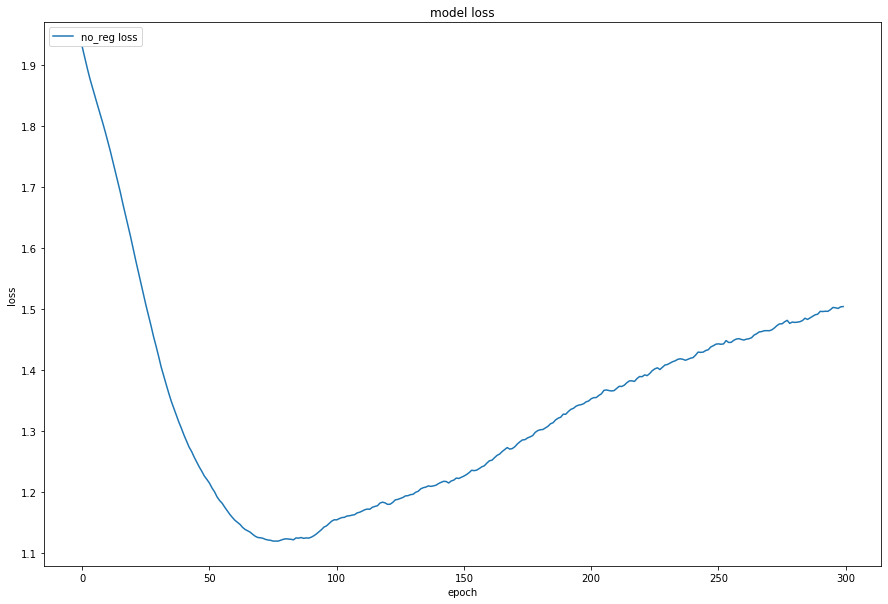

In [9]:
plt.figure(figsize=(15,10))
# summarize history for loss
#plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['no_reg loss'], loc='upper left')
plt.show()

In [10]:
results = model.evaluate(X_test, Y_test, verbose=0)

print(f'Test {model.metrics_names[0]}: {results[0]} \nTest {model.metrics_names[1]}: {results[1]}' )

Test loss: 0.6308204379192618 
Test accuracy: 0.7906976938247681


Let's see how to get better from this.

### Penalities

In [11]:
# create a model with a regularisation term
model_pen = Sequential()
model_pen.add(Dense(10, kernel_initializer='normal',input_dim=n_x, activation='relu',
                    kernel_regularizer= l2(0.01)))
model_pen.add(Dense(n_c, activation='softmax'))

model_pen.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
history_pen = model_pen.fit(X_train, Y_train, batch_size=32, epochs=300, validation_split=0.1,shuffle=True)

Train on 153 samples, validate on 18 samples
Epoch 1/300
153/153 [==============================] - 0s 2ms/step - loss: 1.9503 - accuracy: 0.0523 - val_loss: 1.9203 - val_accuracy: 0.1667
Epoch 2/300
153/153 [==============================] - 0s 104us/step - loss: 1.9346 - accuracy: 0.1307 - val_loss: 1.9039 - val_accuracy: 0.3333
Epoch 3/300
153/153 [==============================] - 0s 51us/step - loss: 1.9190 - accuracy: 0.2222 - val_loss: 1.8875 - val_accuracy: 0.3333
Epoch 4/300
153/153 [==============================] - 0s 50us/step - loss: 1.9036 - accuracy: 0.3268 - val_loss: 1.8715 - val_accuracy: 0.3889
Epoch 5/300
153/153 [==============================] - 0s 50us/step - loss: 1.8879 - accuracy: 0.4510 - val_loss: 1.8570 - val_accuracy: 0.3889
Epoch 6/300
153/153 [==============================] - 0s 50us/step - loss: 1.8720 - accuracy: 0.4771 - val_loss: 1.8431 - val_accuracy: 0.3889
Epoch 7/300
153/153 [==============================] - 0s 110us/step - loss: 1.8562 - accur

Epoch 57/300
153/153 [==============================] - 0s 49us/step - loss: 1.0479 - accuracy: 0.6601 - val_loss: 1.1221 - val_accuracy: 0.5000
Epoch 58/300
153/153 [==============================] - 0s 46us/step - loss: 1.0424 - accuracy: 0.6601 - val_loss: 1.1196 - val_accuracy: 0.5000
Epoch 59/300
153/153 [==============================] - 0s 49us/step - loss: 1.0371 - accuracy: 0.6601 - val_loss: 1.1140 - val_accuracy: 0.5000
Epoch 60/300
153/153 [==============================] - 0s 47us/step - loss: 1.0320 - accuracy: 0.6601 - val_loss: 1.1098 - val_accuracy: 0.5000
Epoch 61/300
153/153 [==============================] - 0s 47us/step - loss: 1.0271 - accuracy: 0.6601 - val_loss: 1.1063 - val_accuracy: 0.5000
Epoch 62/300
153/153 [==============================] - 0s 47us/step - loss: 1.0224 - accuracy: 0.6601 - val_loss: 1.1027 - val_accuracy: 0.5000
Epoch 63/300
153/153 [==============================] - 0s 48us/step - loss: 1.0176 - accuracy: 0.6601 - val_loss: 1.0994 - val_ac

153/153 [==============================] - 0s 48us/step - loss: 0.8044 - accuracy: 0.7386 - val_loss: 1.1809 - val_accuracy: 0.6111
Epoch 170/300
153/153 [==============================] - 0s 48us/step - loss: 0.8036 - accuracy: 0.7386 - val_loss: 1.1852 - val_accuracy: 0.6111
Epoch 171/300
153/153 [==============================] - 0s 48us/step - loss: 0.8025 - accuracy: 0.7386 - val_loss: 1.1857 - val_accuracy: 0.6111
Epoch 172/300
153/153 [==============================] - 0s 48us/step - loss: 0.8015 - accuracy: 0.7386 - val_loss: 1.1854 - val_accuracy: 0.6111
Epoch 173/300
153/153 [==============================] - 0s 47us/step - loss: 0.8006 - accuracy: 0.7386 - val_loss: 1.1890 - val_accuracy: 0.6111
Epoch 174/300
153/153 [==============================] - 0s 47us/step - loss: 0.7996 - accuracy: 0.7386 - val_loss: 1.1909 - val_accuracy: 0.6111
Epoch 175/300
153/153 [==============================] - 0s 48us/step - loss: 0.7986 - accuracy: 0.7386 - val_loss: 1.1923 - val_accuracy:

Epoch 281/300
153/153 [==============================] - 0s 47us/step - loss: 0.7305 - accuracy: 0.7908 - val_loss: 1.3654 - val_accuracy: 0.6111
Epoch 282/300
153/153 [==============================] - 0s 56us/step - loss: 0.7301 - accuracy: 0.7908 - val_loss: 1.3685 - val_accuracy: 0.6111
Epoch 283/300
153/153 [==============================] - 0s 55us/step - loss: 0.7297 - accuracy: 0.7908 - val_loss: 1.3698 - val_accuracy: 0.6111
Epoch 284/300
153/153 [==============================] - 0s 51us/step - loss: 0.7296 - accuracy: 0.7908 - val_loss: 1.3718 - val_accuracy: 0.6111
Epoch 285/300
153/153 [==============================] - 0s 53us/step - loss: 0.7289 - accuracy: 0.7908 - val_loss: 1.3699 - val_accuracy: 0.6111
Epoch 286/300
153/153 [==============================] - 0s 50us/step - loss: 0.7283 - accuracy: 0.7843 - val_loss: 1.3724 - val_accuracy: 0.6111
Epoch 287/300
153/153 [==============================] - 0s 50us/step - loss: 0.7279 - accuracy: 0.7843 - val_loss: 1.3764 -

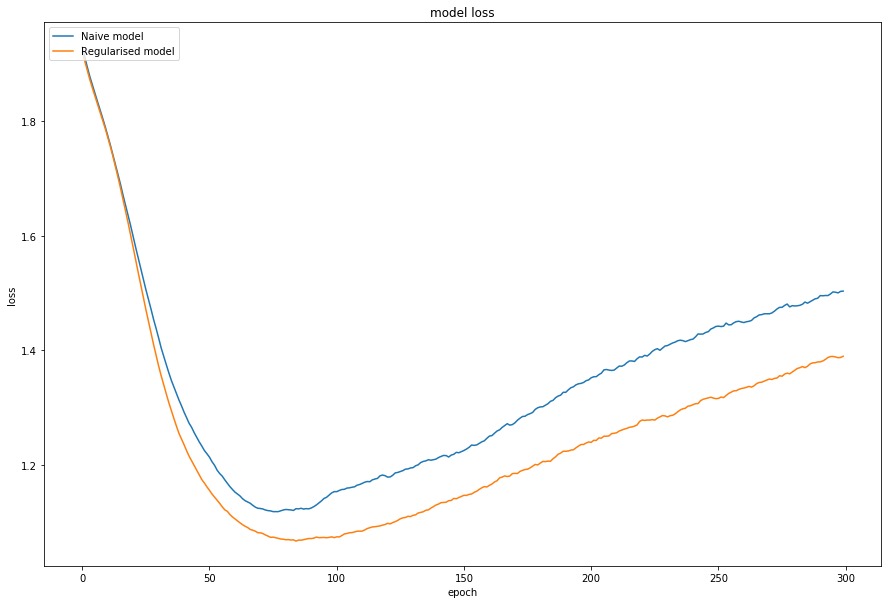

In [13]:
plt.figure(figsize=(15,10))
# summarize history for loss
#plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_pen.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Naive model', 'Regularised model'], loc='upper left')
plt.show()

### Dropout

In [14]:
# create a model with a dropout layer 
model_drp = Sequential()
model_drp.add(Dense(10, kernel_initializer='normal',input_dim=n_x, activation='relu',
                    kernel_regularizer= l2(0.01)))
model_drp.add(Dropout(0.1))
model_drp.add(Dense(7, activation='relu'))
model_drp.add(Dense(n_c, activation='softmax'))

model_drp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
history_drp = model_drp.fit(X_train, Y_train, batch_size=32, epochs=300, validation_split=0.1,shuffle=True)

Train on 153 samples, validate on 18 samples
Epoch 1/300
153/153 [==============================] - 0s 2ms/step - loss: 1.9357 - accuracy: 0.1242 - val_loss: 1.9312 - val_accuracy: 0.1111
Epoch 2/300
153/153 [==============================] - 0s 61us/step - loss: 1.9279 - accuracy: 0.2549 - val_loss: 1.9239 - val_accuracy: 0.1667
Epoch 3/300
153/153 [==============================] - 0s 58us/step - loss: 1.9169 - accuracy: 0.3268 - val_loss: 1.9208 - val_accuracy: 0.1667
Epoch 4/300
153/153 [==============================] - 0s 57us/step - loss: 1.9078 - accuracy: 0.4118 - val_loss: 1.9211 - val_accuracy: 0.2222
Epoch 5/300
153/153 [==============================] - 0s 58us/step - loss: 1.8970 - accuracy: 0.4248 - val_loss: 1.9103 - val_accuracy: 0.2778
Epoch 6/300
153/153 [==============================] - 0s 109us/step - loss: 1.8856 - accuracy: 0.4118 - val_loss: 1.8982 - val_accuracy: 0.2222
Epoch 7/300
153/153 [==============================] - 0s 81us/step - loss: 1.8732 - accura

153/153 [==============================] - 0s 76us/step - loss: 0.9046 - accuracy: 0.6732 - val_loss: 1.0346 - val_accuracy: 0.5556
Epoch 114/300
153/153 [==============================] - 0s 81us/step - loss: 0.8808 - accuracy: 0.6667 - val_loss: 1.1162 - val_accuracy: 0.4444
Epoch 115/300
153/153 [==============================] - 0s 82us/step - loss: 0.9030 - accuracy: 0.6536 - val_loss: 0.9958 - val_accuracy: 0.6111
Epoch 116/300
153/153 [==============================] - 0s 66us/step - loss: 0.9096 - accuracy: 0.6863 - val_loss: 1.0441 - val_accuracy: 0.6111
Epoch 117/300
153/153 [==============================] - 0s 75us/step - loss: 0.8888 - accuracy: 0.6471 - val_loss: 1.0878 - val_accuracy: 0.5556
Epoch 118/300
153/153 [==============================] - 0s 80us/step - loss: 0.8653 - accuracy: 0.6797 - val_loss: 1.1132 - val_accuracy: 0.4444
Epoch 119/300
153/153 [==============================] - 0s 73us/step - loss: 0.8924 - accuracy: 0.6471 - val_loss: 1.0631 - val_accuracy:

Epoch 225/300
153/153 [==============================] - 0s 61us/step - loss: 0.7925 - accuracy: 0.6863 - val_loss: 1.0342 - val_accuracy: 0.6667
Epoch 226/300
153/153 [==============================] - 0s 62us/step - loss: 0.7896 - accuracy: 0.7190 - val_loss: 1.0710 - val_accuracy: 0.5556
Epoch 227/300
153/153 [==============================] - 0s 62us/step - loss: 0.8196 - accuracy: 0.6601 - val_loss: 0.9810 - val_accuracy: 0.6111
Epoch 228/300
153/153 [==============================] - 0s 70us/step - loss: 0.7827 - accuracy: 0.7059 - val_loss: 1.0910 - val_accuracy: 0.6667
Epoch 229/300
153/153 [==============================] - 0s 62us/step - loss: 0.8000 - accuracy: 0.6993 - val_loss: 0.8224 - val_accuracy: 0.7222
Epoch 230/300
153/153 [==============================] - 0s 62us/step - loss: 0.7978 - accuracy: 0.7059 - val_loss: 1.1162 - val_accuracy: 0.6111
Epoch 231/300
153/153 [==============================] - 0s 110us/step - loss: 0.8261 - accuracy: 0.6405 - val_loss: 0.9869 

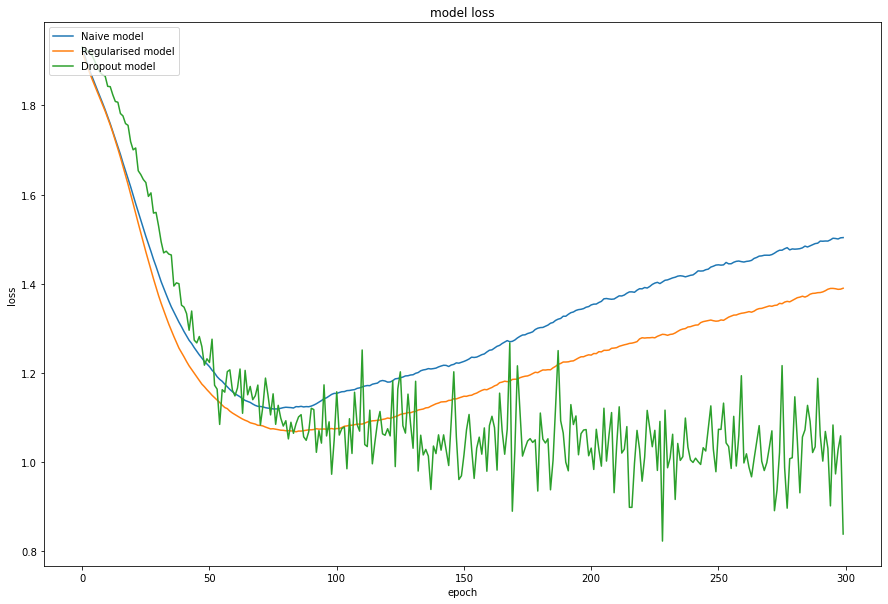

In [16]:
plt.figure(figsize=(15,10))
# summarize history for loss
#plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history_pen.history['val_loss'])
plt.plot(history_drp.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Naive model', 'Regularised model', 'Dropout model'], loc='upper left')
plt.show()

## Another regularisation technique: Early Stopping

Have a look at the plot above. All the losses are decresing until aroung epoch $75$. Stopping at this step (_i.e._ in general reducing epochs) might reduce overfitting issues.

![](https://miro.medium.com/max/1400/1*2zD7wwIwhIrHdr8F4urF2w.png)

## What you should remember
- Very deep "plain" networks don't work in practice because they are hard to train due to overfit and misprediction problems. 
- Fighting overfit means keeping a bit less attention on training set, to generalise better on new data.

### References  

- A quite nice and not too technical reading is [this medium blog post](https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e)
- Francois Chollet's GitHub repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
